#### В этом ноутбуке:  
* мы кросс-валидируем 6 моделей для GK и NKTD каротажей, по 3 на каждый каротаж, по числу тестовых фолдов. Словарь `longwells_dataset` (файл `longwells_dataset_alt.pkl`) содержит случайное разбиение датасета "длинных" каротажей на 3 равных фолда, которые используются для тренировки и тестирования. Тренировочные подмножества данных не содержат тестовые скважины (их проекции) и наоборот. Мы последовательно извлекаем тестовые подмножества и предсказываем их моделями, натренированными на остальной части данных. 


* Словарь `weights` может быть заполнен собственными моделями. При этом для корректного тестирования надо соблюдать их порядок в кортеже, где они идут в порядке тестовых фолдов:  
`uResNet34.GK.sz1024x512.sgl_0.96-0.70.hdf5`,  
`uResNet34.GK.sz1024x512.sgl_1.97-0.67.hdf5`,  
`uResNet34.GK.sz1024x512.sgl_2.102-0.71.hdf5`  


* Затем мы подсчитываем статистику и визуализируем результаты. Объединяя всё, мы должны получить такую статистику, где `i` номер фолда:  

    GK  
    i=0: corr: 0.8079767402716361 corr smoothed: 0.8651451103247031  
    i=1: corr: 0.7798979688516176 corr smoothed: 0.8417930165000221  
    i=2: corr: 0.8160069325329081 corr smoothed: 0.8780798747226374  

    NKTD  
    i=0: corr: 0.822611946034374 corr smoothed: 0.8677347866106758  
    i=1: corr: 0.8517454319121562 corr smoothed: 0.8972354635632236  
    i=2: corr: 0.8394309373878427 corr smoothed: 0.879250483276507  


* Рисуем тренировочный лог
* Визуализируем прогноз каротажного среза  
* Создаем каротажный куб

In [36]:
# reload modules automatically:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore')

# make user code available:
import sys
from pathlib import Path
module_path = str(Path('../src').absolute())
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from keras import backend as K
from model1 import uResNet34
from data_gen1 import SliceIterator, primary_transform
from const import (
    norm_dict_path,
    log_dir,
    slices_dir,
    model_dir,
    data_dir,
    crossval_dict,  # словарь путей к данным разбитыми на 4 фолда для кросс-валидации
    wells,  # спикок скважин с "длинными" каротажами
)
from train_model import get_train_test_split

import numpy as np
import pandas as pd
import re
import cv2
import pickle
from shutil import copyfile
import segyio
from itertools import chain, islice
import matplotlib.pyplot as plt
import matplotlib.colors as colors

model_class = uResNet34
model_dir = model_dir / 'raw'  # общий путь к моделям
image_size = (480, 512)

with open(norm_dict_path, 'rb') as f:
    norm_dict = pickle.load(f)
    
cv_dataset = get_train_test_split(slices_dir, crossval_dict)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# натренированные модели. см. комментарий об упорядоченности
weights_ = {
    'Gamma_Ray': [
        'uResNet34.Gamma_Ray.sz480x512.smtd_0.14-0.78.hdf5',
        'uResNet34.Gamma_Ray.sz480x512.smtd_1.11-0.37.hdf5',
        'uResNet34.Gamma_Ray.sz480x512.smtd_2.07-0.65.hdf5',
        'uResNet34.Gamma_Ray.sz480x512.smtd_3.42-0.67.hdf5'
    ],
}

weights = {
    'Gamma_Ray': [
        'uResNet34.Gamma_Ray.sz480x512.sgl_0.149-0.74.hdf5',
        'uResNet34.Gamma_Ray.sz480x512.sgl_1.143-0.28.hdf5',
        'uResNet34.Gamma_Ray.sz480x512.sgl_2.11-0.66.hdf5',
        'uResNet34.Gamma_Ray.sz480x512.sgl_3.145-0.73.hdf5'
    ],
}

In [20]:
def predict_on_fold(slice_list, carotage, model_weights, verbose=False):
    """предсказываем модель для одного фолда"""
    norm = [(norm_dict[c]['mean'], norm_dict[c]['std']) for c in ['seismic', carotage]]

    K.clear_session()
    model = model_class(input_size=image_size, weights=model_weights, n_carotage=1)
    gen = SliceIterator(slice_list, [carotage], image_size, transform_fun=primary_transform, norm=norm, aug=False,
                        batch_size=10, shuffle=False, seed=None, verbose=False, output_ids=True, infinite_loop=False)
    x_m, y, ids = zip(*gen)
    x, m = zip(*x_m)
    x = np.concatenate(x)
    m = np.concatenate(m)
    y = np.concatenate(y)
    ids = list(chain(*ids))

    pred = model.predict([x, m], batch_size=4)

    data = []
    for seismic, mask, y_true, p, i_d in zip(x, m, y, pred, ids):
        designation_size = (750 - 100 + 1, 462) if 'xline' in i_d else (1250 - 300 + 1, 462)
        y_pred = p[..., :1]

        seism = cv2.resize(seismic[..., 0], dsize=designation_size, interpolation=cv2.INTER_CUBIC)
        mask = cv2.resize(mask[..., 0], dsize=designation_size, interpolation=cv2.INTER_NEAREST)
        y_true = cv2.resize(y_true[..., 0], dsize=designation_size, interpolation=cv2.INTER_NEAREST)
        y_pred = cv2.resize(y_pred[..., 0], dsize=designation_size, interpolation=cv2.INTER_NEAREST)

        corr = np.corrcoef(y_true[mask.astype(bool)], y_pred[mask.astype(bool)])[0, 1]
        data.append({'seism': seism, 'mask': mask, 'y_true': y_true, 'y_pred': y_pred, 'corr': corr, 'id': i_d})
    if verbose:
        # "грубая" корреляция по пикселям картинке. в основных расчетах не используется
        print(f'corr={np.mean([d["corr"] for d in data if ~np.isnan(d["corr"])])}')
    return data

In [25]:
def smoothed_corr(i_d, x, pred_line, carotage, T=50, window=125):
    """считаем корреляцию по сглаженным данным"""
    
    ## читаем каротаж
    data = pd.read_csv(log_dir / (re.match('.+_.+_(.+)', i_d)[1] + '.csv'))
    z = data[['t', carotage]].to_numpy()
    ## х-координаты сейсмики
    xs = x[~np.isnan(x)]

    z_avg_exp = [ ]
    ## бежим по сейсмике
    for i in range(xs.shape[0]):
        ## ближайший слева индекс в каротаже
        last_index = np.where(z[:,0] < xs[i])[0]
        if len(last_index) == 0:
            last_index = 0
        else:
            last_index = last_index[-1]
        ## берём плюс-минус ширину окна, убираем nan
        cur_values = z[ max(0, last_index - window) : (last_index + window), : ]
        cur_values = cur_values[~np.isnan(cur_values[:, 1])]
        ## расстояния
        cur_dists = np.abs(cur_values[:, 0] - xs[i])
        cur_exp_weights = np.exp(-cur_dists/T) / np.sum(np.exp(-cur_dists/T))
        z_avg_exp.append(np.dot(cur_exp_weights, cur_values[:, 1]))
    avg_exp_results = np.array(z_avg_exp)
    
    preds = pred_line[~np.isnan(x)]
    return np.corrcoef(avg_exp_results, preds)[0, 1] 

In [27]:
def eval_fold_correlation(data, carotage):
    """функция возвращает 2 списка корреляций, несглаженные, сглаженные и словарь viz_data для визуализации"""
    
    mean, std = norm_dict[carotage]['mean'], norm_dict[carotage]['std']
    correlations, correlations_smoothed = [], []
    viz_data = []
    for d in data:
        mask = d['mask'].astype(int)
        y_true = d['y_true']
        y_pred = d['y_pred']
        i_d = d['id']

        true_line = (y_true * mask).sum(1) / mask.sum(1) * std + mean
        pred_line = (y_pred * mask).sum(1) / mask.sum(1) * std + mean
        x = np.arange(len(y_true), dtype=float) * 2
        x[mask.sum(1) == 0] = np.nan

        corr = np.corrcoef(true_line[~np.isnan(true_line)], pred_line[~np.isnan(pred_line)])[0, 1]
        correlations.append(corr)
        corr_smth = smoothed_corr(i_d, x, pred_line, carotage, T=50, window=150)
        correlations_smoothed.append(corr_smth)

        viz_data.append({'i_d': i_d, 'x': x, 'true_line': true_line, 'pred_line': pred_line, 'corr': (corr, corr_smth)})
    
    correlations = np.array(correlations)
    correlations = correlations[~np.isnan(correlations)]
    correlations_smoothed = np.array(correlations_smoothed)
    correlations_smoothed = correlations_smoothed[~np.isnan(correlations_smoothed)]

    return correlations, correlations_smoothed, viz_data

In [23]:
def process_all_folds(carotage):
    """обрабатываем все фолды для данного каротажа и возвращаем корреляции и фактические и предсказанные данные"""
    
    folds = range(len(cv_dataset))
    all_fold_correlation, all_fold_correlation_smoothed, all_viz = [], [], []
    for fold in folds:
        model_weights =  model_dir / weights[carotage][fold]
        slice_list = cv_dataset[fold]['test']
        data = predict_on_fold(slice_list, carotage, model_weights, verbose=False)
        correlations, correlations_smoothed, viz_data = eval_fold_correlation(data, carotage)
        print('fold:', fold, 'corr:', np.mean(correlations), 'corr smoothed:', np.mean(correlations_smoothed))
        all_fold_correlation.extend(correlations)
        all_fold_correlation_smoothed.extend(correlations_smoothed)
        all_viz.extend(viz_data)
    return all_fold_correlation, all_fold_correlation_smoothed, all_viz

In [38]:
correlation_dict = {}
for c in ['Gamma_Ray']:
    all_fold_correlation, all_fold_correlation_smoothed, all_viz = process_all_folds(c)
    correlation_dict[c] = all_fold_correlation, all_fold_correlation_smoothed, all_viz
    print(f'carotage {c} all-fold correlation:')
    print('not smoothed:', np.mean(all_fold_correlation))
    print('smoothed:', np.mean(all_fold_correlation_smoothed))

Load weights from ..\models\raw\uResNet34.Gamma_Ray.sz480x512.sgl_0.149-0.74.hdf5


[Run:AI] [DEBUG   ] [26-05-2020 13:18:21.865] [6820] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps
I0526 13:18:21.865000  5360 optimizers.py:16] Wrapping 'Adam' Keras optimizer with GA of 16 steps


fold: 0 corr: 0.8515898882169491 corr smoothed: 0.5964672226055241
Load weights from ..\models\raw\uResNet34.Gamma_Ray.sz480x512.sgl_1.143-0.28.hdf5


[Run:AI] [DEBUG   ] [26-05-2020 13:18:37.126] [6820] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps
I0526 13:18:37.126000  5360 optimizers.py:16] Wrapping 'Adam' Keras optimizer with GA of 16 steps


fold: 1 corr: 0.3411353019644692 corr smoothed: 0.11454629544803963
Load weights from ..\models\raw\uResNet34.Gamma_Ray.sz480x512.sgl_2.11-0.66.hdf5


[Run:AI] [DEBUG   ] [26-05-2020 13:18:52.860] [6820] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps
I0526 13:18:52.860999  5360 optimizers.py:16] Wrapping 'Adam' Keras optimizer with GA of 16 steps


fold: 2 corr: 0.73453082990497 corr smoothed: 0.30451045688067024
Load weights from ..\models\raw\uResNet34.Gamma_Ray.sz480x512.sgl_3.145-0.73.hdf5


[Run:AI] [DEBUG   ] [26-05-2020 13:19:08.973] [6820] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps
I0526 13:19:08.973000  5360 optimizers.py:16] Wrapping 'Adam' Keras optimizer with GA of 16 steps


fold: 3 corr: 0.7672299601717808 corr smoothed: 0.38624885545000937
carotage Gamma_Ray all-fold correlation:
not smoothed: 0.6736214950645424
smoothed: 0.35044320759606085


In [43]:
correlation_dict['Gamma_Ray'][0][0]['i_d']

IndexError: invalid index to scalar variable.

### Визуализация

#### Гистограммы корреляций для обоих каротажей, без и со сглаживанием

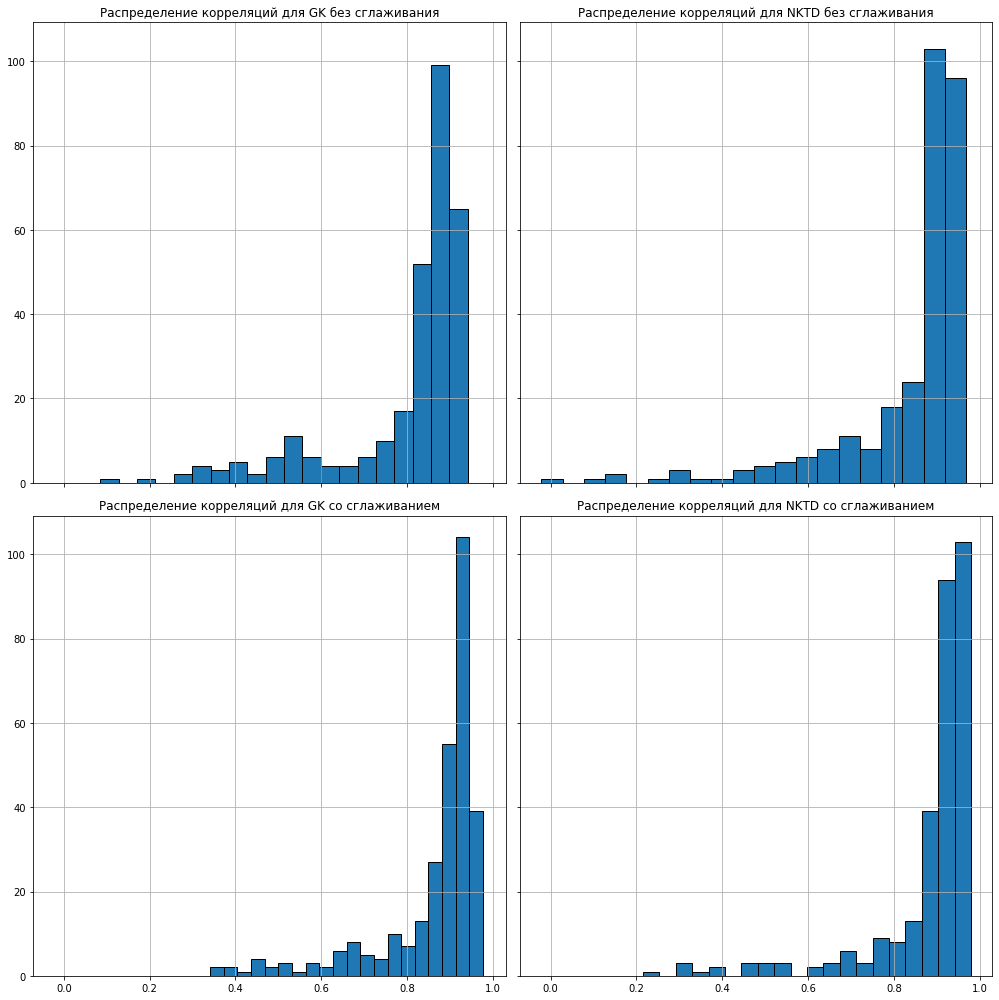

In [8]:
# количество данных превосходит количество скважин вдвое, т.к. каждая скважина проецируется на 2 среза
fig, ax = plt.subplots(2, 2, figsize=(14, 14), sharex=True, sharey=True)
ax[0, 0].hist(correlation_dict['GK'][0], bins=20, edgecolor='black', linewidth=1.0)
ax[0, 0].grid('on')
ax[0, 0].set_title('Распределение корреляций для GK без сглаживания')

ax[1, 0].hist(correlation_dict['GK'][1], bins=20, edgecolor='black', linewidth=1.0)
ax[1, 0].grid('on')
ax[1, 0].set_title('Распределение корреляций для GK со сглаживанием')

ax[0, 1].hist(correlation_dict['NKTD'][0], bins=20, edgecolor='black', linewidth=1.0)
ax[0, 1].grid('on')
ax[0, 1].set_title('Распределение корреляций для NKTD без сглаживания')

ax[1, 1].hist(correlation_dict['NKTD'][1], bins=20, edgecolor='black', linewidth=1.0)
ax[1, 1].grid('on')
ax[1, 1].set_title('Распределение корреляций для NKTD со сглаживанием')

plt.tight_layout()
# plt.savefig('images/corr_distr.png')
plt.show()

#### Несколько произвольных примеров предсказаний, по 4 на каротаж

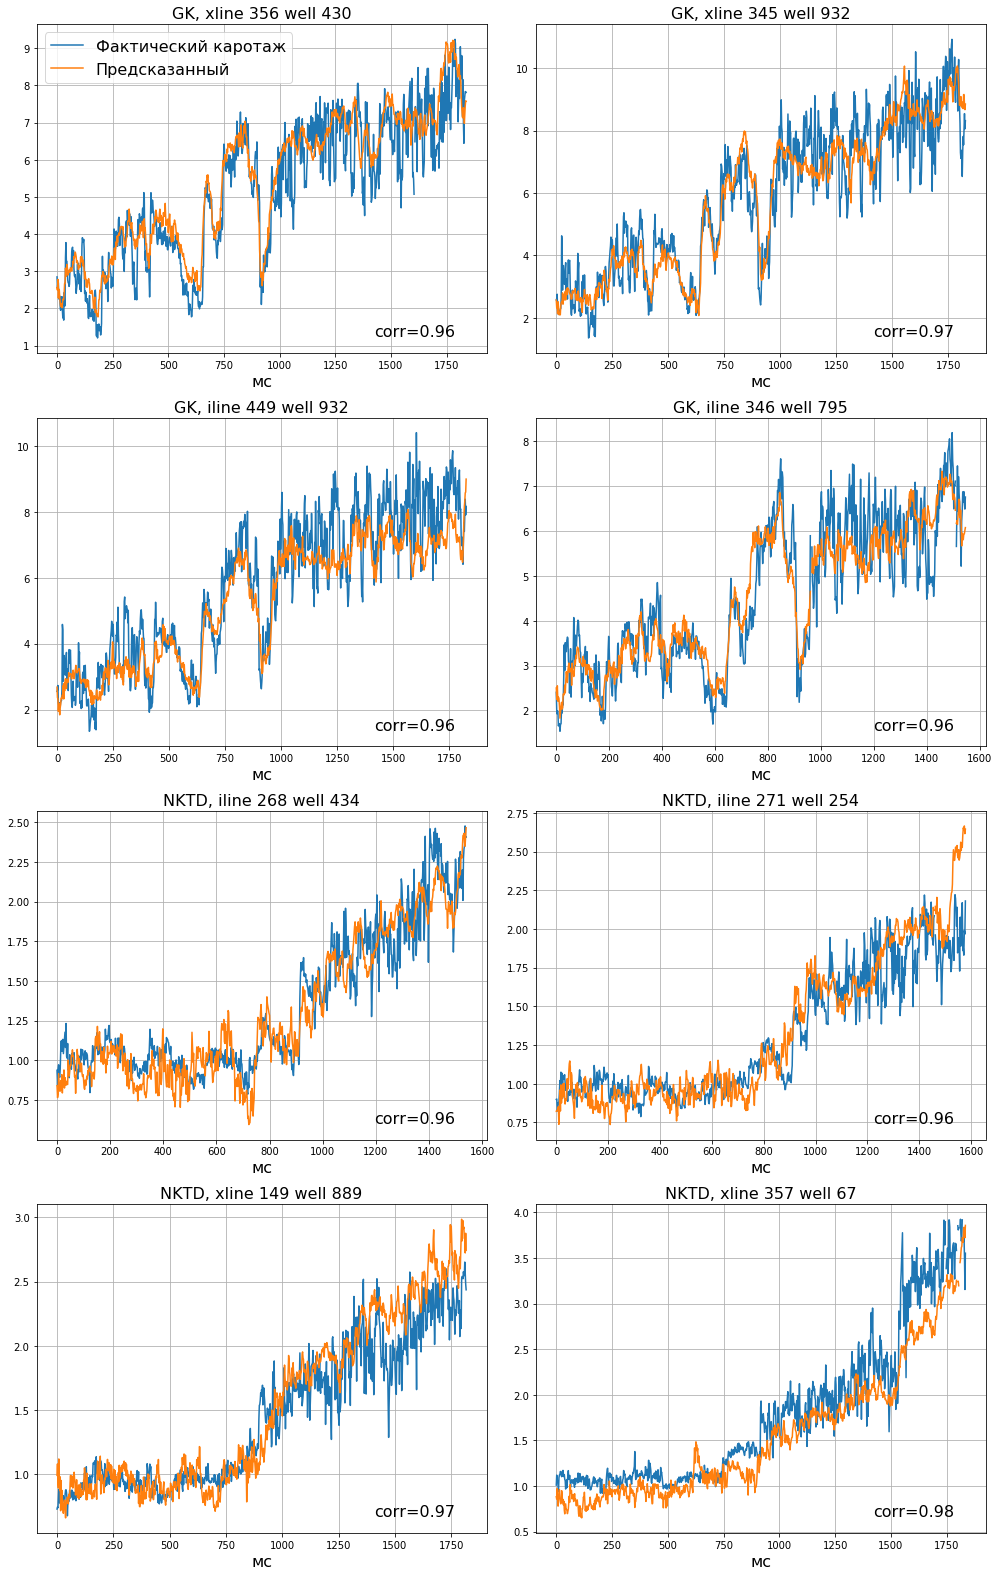

In [9]:
gk = [278, 275, 235, 220]
nktd = [109, 111, 152, 179]
carotages = ['GK'] * len(gk) + ['NKTD'] * len(nktd)

fontsize = 16
fig, axs = plt.subplots(4, 2, figsize=(14, 22), sharex=False)
for i, (gk_i, c_i, ax) in enumerate(zip(gk + nktd, carotages, axs.flatten()[:len(gk) + len(nktd)])):
    viz = correlation_dict[c_i][2][gk_i]
    i_d = viz['i_d']
    x = viz['x']
    true_line = viz['true_line']
    pred_line = viz['pred_line']
    corr = viz['corr'][1]
    
    ax.plot(x, true_line, x, pred_line)
    ax.set_xlabel('мс', fontsize=fontsize)
    ax.set_title(r'{}, {} {} {} {}'.format(c_i, *i_d.split('_')), fontsize=fontsize)
    if i == 0:
        ax.legend(['Фактический каротаж', 'Предсказанный'], fontsize=fontsize)
    ax.text(0.75, 0.05, f'corr={corr:0.2f}', transform=ax.transAxes, fontsize=fontsize)
    ax.grid(True)
    
plt.tight_layout()
# plt.savefig(f'images/predicted_carotage_long.png')
plt.show()

#### Визуализируем срез с предсказанным каротажем

In [11]:
fold = 0
slice_list = longwells_dataset[fold]['test']
carotage = 'GK'
data = predict_on_fold(slice_list, carotage, model_dir / weights[carotage][fold], verbose=False)

Load weights from ..\models\longwells\uResNet34.GK.sz1024x512.sgl_0.96-0.70.hdf5


[Run:AI] [DEBUG   ] [30-04-2020 23:12:41.441] [3988] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps
I0430 23:12:41.441999  7284 optimizers.py:16] Wrapping 'Adam' Keras optimizer with GA of 16 steps


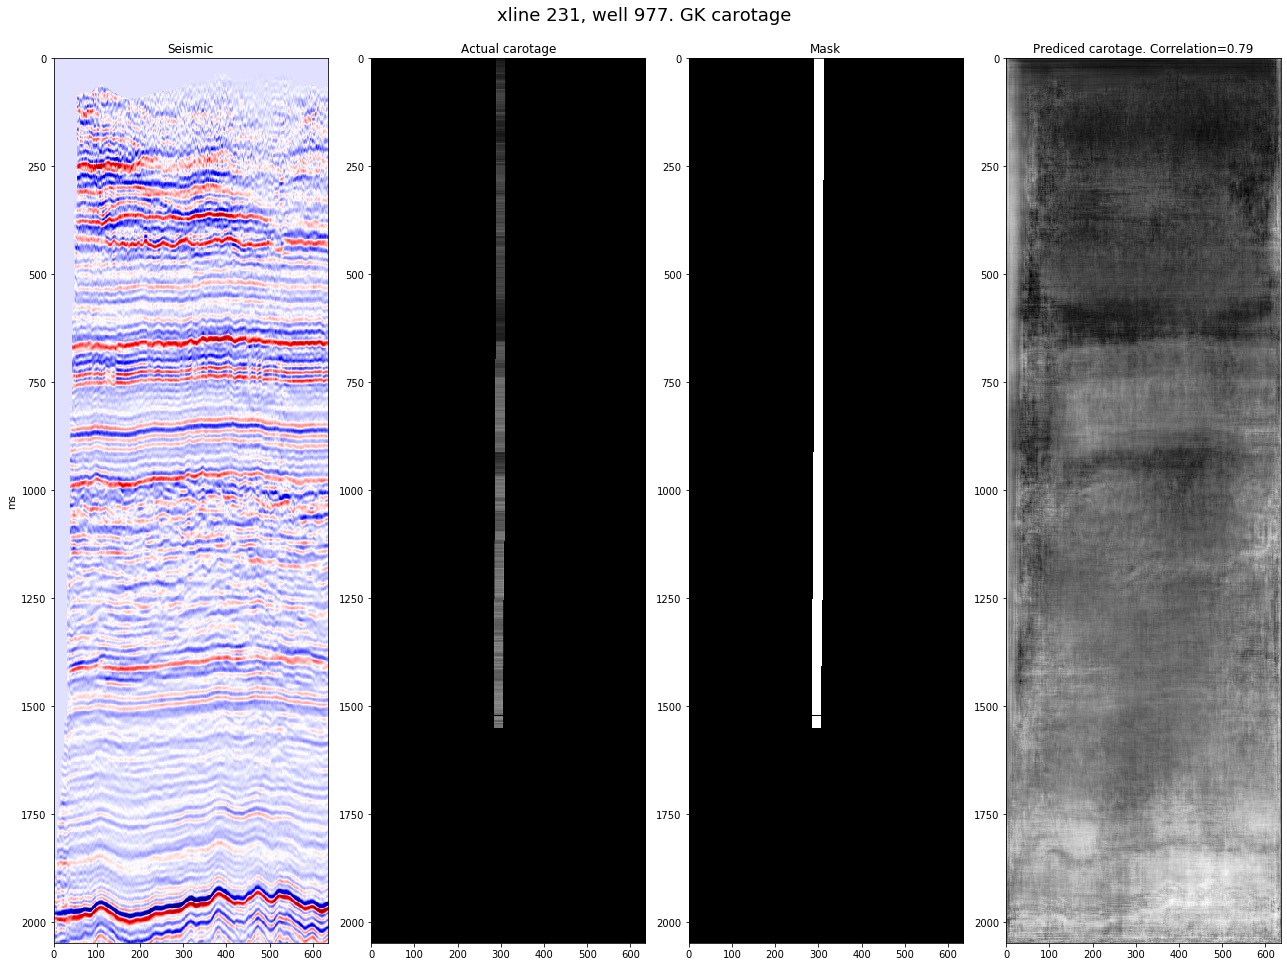

In [12]:
d = data[60]

color_norm = colors.Normalize(vmin=d['y_pred'].min(), vmax=d['y_pred'].max())
extent = [0, d['seism'].shape[1] - 1, d['seism'].shape[0] * 2 - 1, 0]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 14), sharey=False)
ax1.imshow(d['seism'], cmap='seismic', extent=extent)
ax1.set_title('Seismic')
ax1.set_ylabel('ms', fontsize='10')

ax2.imshow(d['y_true'], cmap='Greys_r', extent=extent, norm=color_norm)
ax2.set_title('Actual carotage')

ax3.imshow(d['mask'], extent=extent, cmap='Greys_r')
ax3.set_title('Mask')

ax4.imshow(d['y_pred'], cmap='Greys_r', extent=extent, norm=color_norm)
ax4.set_title(f'Prediced carotage. Correlation={d["corr"]:.2f}')

plt.tight_layout()
plt.suptitle(f'{{}} {{}}, {{}} {{}}. {carotage} carotage'.format(*d['id'].split('_')), fontsize=18, y=0.99)
plt.show()

### Построение каротажного куба

In [3]:
time_grid = np.arange(1024) * 2
meters_grid = np.arange(2500)

# создадим урезанный до верхней трети сейсмический куб 
seismic_cut_path = data_dir / 'seismic_cut.sgy'
create_zero_cube(seg_path, seismic_cut_path, time_grid, ilines, xlines)
with segyio.open(seg_path) as segyfile:
    segyfile.mmap()
    with segyio.open(seismic_cut_path, mode='r+') as f:
        f.mmap()
        for iline in ilines:
            seismic_slice = segyfile.iline[iline]
            f.iline[iline] = seismic_slice[..., : len(time_grid)]
        f.flush()

# и "нулевой" куб с метрической осью Z        
# оба куба достаточно создать один раз, дальше они будут копироваться
zero_cube_path = data_dir / 'zero_cube_meters.sgy'
create_zero_cube(seg_path, zero_cube_path, meters_grid, ilines, xlines)

In [4]:
# пре- и постпроцессинг
def preprocess(x, dsize, mean, std):
    # in:  n x h0 x w0
    # ret: n x h1 x w1 x 1
    x = np.moveaxis(x, 0, -1)
    x = (x - mean) / std
    x = cv2.resize(x, dsize=dsize[::-1], interpolation=cv2.INTER_CUBIC)
    x = np.moveaxis(x, -1, 0)[..., np.newaxis]
    return x

def postprocess(x, dsize, mean, std):
    # in:  n x h1 x w1
    # ret: n x h0 x w0    
    x = np.moveaxis(x, 0, -1)
    x = cv2.resize(x, dsize=dsize[::-1], interpolation=cv2.INTER_NEAREST)
    x = x * std + mean
    x = np.moveaxis(x, -1, 0)
    return x

In [5]:
batch_size = 16
with open(norm_dict_path, 'rb') as f:
    norm_dict = pickle.load(f)
seismic_mean, seismic_std = norm_dict['seismic']['mean'], norm_dict['seismic']['std'] # для нормализации сейсмограммы
modelsize = (1024, 512)

# датафрейм с корректировками layer0 по трассам
layer0corr = pd.read_csv(data_dir / 'traces_layer0_added.csv')

# vsp функция
vsp_fun = get_vsp()

In [8]:
originalsize = (1024, 810) # будем двигаться по инлайнам, поэтому выбираем целевой размер кросслайна

# возьмём модель для первого фолда; как следствие, тестовыми скважинами для такого куба будут скважины из 1-го тестового фолда
carotage = 'NKTD'
fold = 0

mean, std = norm_dict[carotage]['mean'], norm_dict[carotage]['std']  # для нормализации каротажа
model_weights = model_dir / weights[carotage][fold]
model_class = uResNet34

target_cube_path = cube_dir / (carotage + '.sgy')
copyfile(zero_cube_path, target_cube_path)  # будем писать в подготовленный куб, для этого копируем "нулевой"

# инициализируем модель
K.clear_session()
model = model_class(input_size=modelsize, weights=model_weights, n_carotage=1)

W0430 22:28:49.579999  5364 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Load weights from ..\models\longwells\uResNet34.NKTD.sz1024x512.sgl_0.98-0.72.hdf5


[Run:AI] [DEBUG   ] [30-04-2020 22:29:00.756] [5204] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps
I0430 22:29:00.756999  5364 optimizers.py:16] Wrapping 'Adam' Keras optimizer with GA of 16 steps
W0430 22:29:00.776000  5364 deprecation.py:323] From f:\Sandbox\gpn\notebooks\..\src\model1.py:88: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
# основной цикл
with segyio.open(seismic_cut_path, 'r') as segyfile:
    segyfile.mmap()
    with segyio.open(target_cube_path, mode='r+') as f:
        f.mmap()
        # цикл по инлайнам
        for bx, i in enumerate(range(0, len(ilines), batch_size)):
            iline_batch = ilines[i: min(i + batch_size, len(ilines))]
            print(f'batch {bx + 1}/{int(np.ceil(len(ilines) / batch_size))}, len={len(iline_batch)}')
            seismic = np.asarray([np.copy(x) for x in segyfile.iline[iline_batch.min(): iline_batch.max() + 1]])
            seismic = np.moveaxis(seismic, 2, 1)
            seismic = preprocess(seismic, modelsize, seismic_mean, seismic_std)
            mask = np.zeros_like(seismic, dtype=np.float32)

            pred = model.predict([seismic, mask], batch_size=8)[..., 0]
            pred = postprocess(pred, originalsize, mean, std)
            
            # цикл по инлайнам в батче
            for idx, iline_batch_index in enumerate(iline_batch):
                # читаем корректировки кросслайнов для инлайна с номером iline_batch_index
                l0corr = layer0corr.loc[layer0corr['Inline'] == iline_batch_index].sort_values('Crossline')['layer_0_correction'].values
                # переводим каротажный срез из секунд в метры
                p_meters = rescale_seconds2meters(pred[idx], l0corr, time_grid=time_grid, meters_grid=meters_grid)
                f.iline[iline_batch_index] = p_meters.T

batch 1/40, len=16


W0430 22:29:54.464999  5364 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



batch 2/40, len=16
batch 3/40, len=16
batch 4/40, len=16
batch 5/40, len=16
batch 6/40, len=16
batch 7/40, len=16
batch 8/40, len=16
batch 9/40, len=16
batch 10/40, len=16
batch 11/40, len=16
batch 12/40, len=16
batch 13/40, len=16
batch 14/40, len=16
batch 15/40, len=16
batch 16/40, len=16
batch 17/40, len=16
batch 18/40, len=16
batch 19/40, len=16
batch 20/40, len=16
batch 21/40, len=16
batch 22/40, len=16
batch 23/40, len=16
batch 24/40, len=16
batch 25/40, len=16
batch 26/40, len=16
batch 27/40, len=16
batch 28/40, len=16
batch 29/40, len=16
batch 30/40, len=16
batch 31/40, len=16
batch 32/40, len=16
batch 33/40, len=16
batch 34/40, len=16
batch 35/40, len=16
batch 36/40, len=16
batch 37/40, len=16
batch 38/40, len=16
batch 39/40, len=16
batch 40/40, len=12


#### Посмотрим, что получилось

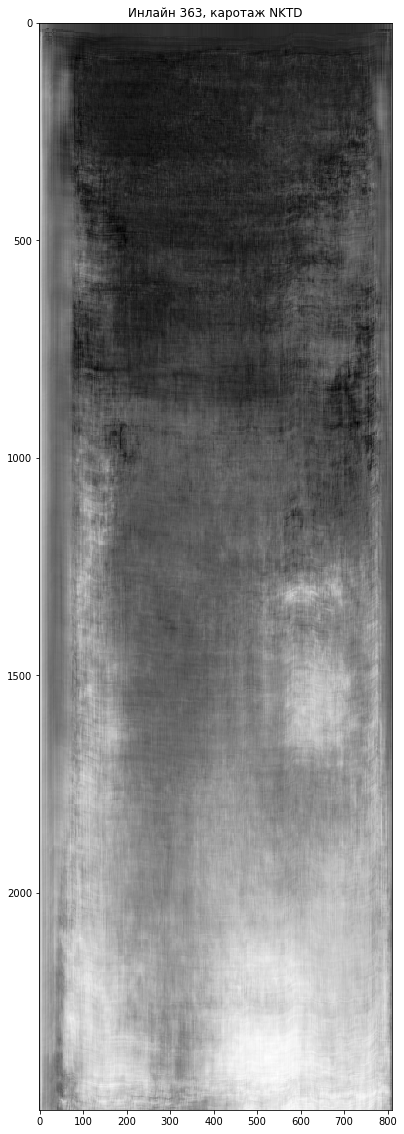

In [16]:
idx = 363  # номер инлайна
with segyio.open(target_cube_path) as f:
    f.mmap()
    carotage_slice = f.iline[idx].T

plt.figure(figsize=(18, 20))
plt.imshow(carotage_slice, cmap='Greys_r')
plt.title(f'Инлайн {idx}, каротаж {carotage}')
plt.show()